## **Shapley value**

The KernelExplainer builds a weighted linear regression by using your data, your predictions, and whatever function that predicts the predicted values. It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression.

This gives us:

* **Global interpretability**: contribution of each variable over the target in general.


* **Local interpretability**: for an individual observation how each variable contribute to this.

**Disadvantages**

* Long running time. 
* Not optimized for all models like for example (knn)

**Recomendations/Alternatives**

* For **tree-based machine learning model**, you should use the tree explainer **TreeExplainer()** that has been optimized to render fast results. 
* For **deep learning model**, use the deep learning explainer **DeepExplainer()**. 

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# The target variable is 'quality'.

/Users/erikapat/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('data/winequality-red.csv', sep = ';') # Load the data
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## **Random forest**

Just to check, we first try a tree-based model, but keep in mind that **TreeExplainer()** is better.

[0.02771784 0.14608857 0.0098873  0.03979135 0.03834853 0.02349039
 0.07114265 0.01940386 0.04327445 0.20548462 0.37537044]


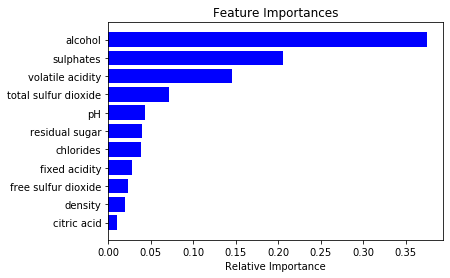

In [4]:
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The function KernelExplainer() below performs a local regression by taking the prediction method rf.predict and the data that you want to perform the SHAP values. Here I use the test dataset X_test which has 160 observations. This step can take a while

In [5]:
#!pip install shap
#conda install -c conda-forge shap

In [16]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

## **The summary plot**
This plot has loaded information. It shows the positive and negative relationships of the predictors with the target variable. It looks dotty because it is made of all the dots in the train data. 

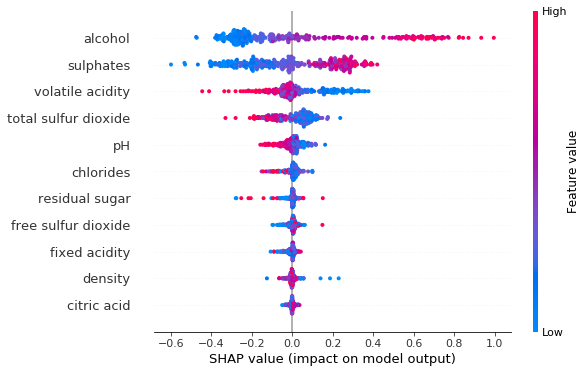

In [13]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

* **Feature importance**: Variables are ranked in descending order.
* **Impact**: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* **Original value:** Color shows whether that variable is high (in red) or low (in blue) for that observation.
* **Correlation:** A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say “volatile acidity” is negatively correlated with the target variable.

## **The dependence plot**

It shows the marginal effect that one or two variables have on the predicted outcome. It tells whether the relationship between the target and the variable is linear, monotonic or more complex. Suppose we want to get the dependence plot of “alcohol”. The following plot shows that there is an approximately linear and positive trend between “alcohol” and the target variable, and “alcohol” interacts with “sulphates” frequently.

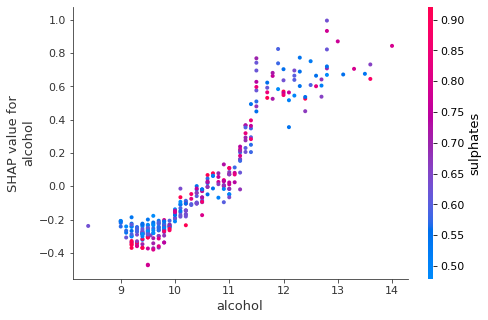

In [18]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("alcohol", shap_values, X_test)